[View in Colaboratory](https://colab.research.google.com/github/pxfang/Hand-Drawn-Object-Recognition/blob/master/Object_Recognition_and_Prediction.ipynb)

# Retrieve Dataset Classes

This file contains a 100-class subset of the Google QuickDraw dataset classes.

In [6]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2018-08-16 02:09:34--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2018-08-16 02:09:34 (71.1 MB/s) - ‘mini_classes.txt’ saved [760/760]



Read/open the classes names

In [0]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download Dataset 

Loop over the classes and download the corresponding data

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [12]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Import libraries

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Loading Data 

Each class contains different number of samples of arrays stored in .npy format. Due to memory limitations, we will load 4000 images per class.  

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [16]:
print(len(x_train))

320000


Print a randomized dataset class:

umbrella


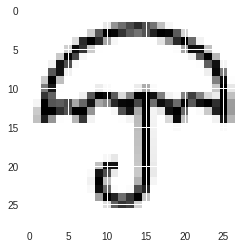

In [87]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocessing Data 

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Convolutional Neural Network Model 

In [89]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
__________

# Model Training

In [90]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Train on 288000 samples, validate on 32000 samples
Epoch 1/5
 - 443s - loss: 1.8751 - top_k_categorical_accuracy: 0.7893 - val_loss: 1.3656 - val_top_k_categorical_accuracy: 0.8784
Epoch 2/5
 - 461s - loss: 1.2119 - top_k_categorical_accuracy: 0.8962 - val_loss: 1.1508 - val_top_k_categorical_accuracy: 0.9023
Epoch 3/5
 - 477s - loss: 1.0599 - top_k_categorical_accuracy: 0.9128 - val_loss: 1.0536 - val_top_k_categorical_accuracy: 0.9142
Epoch 4/5
 - 462s - loss: 0.9717 - top_k_categorical_accuracy: 0.9220 - val_loss: 1.0010 - val_top_k_categorical_accuracy: 0.9178
Epoch 5/5
 - 470s - loss: 0.9146 - top_k_categorical_accuracy: 0.9276 - val_loss: 0.9599 - val_top_k_categorical_accuracy: 0.9228


# Model Testing 

In [91]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:0.2f}%'.format(score[1] * 100))

Test accuracy: 92.40%


# Model Inference 

['car', 'headphones', 'helmet', 'bicycle', 'scissors']


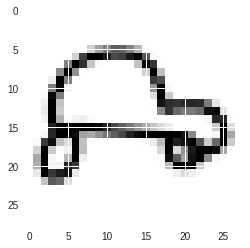

In [98]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store Classes 

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [100]:
!pip install tensorflowjs 

    100% |████████████████████████████████| 12.2MB 2.0MB/s 
    100% |████████████████████████████████| 51.1MB 371kB/s 
    100% |████████████████████████████████| 61kB 17.3MB/s 
    100% |████████████████████████████████| 3.3MB 6.2MB/s 
  Found existing installation: numpy 1.14.5
    Uninstalling numpy-1.14.5:
      Successfully uninstalled numpy-1.14.5
  Found existing installation: tensorboard 1.10.0
    Uninstalling tensorboard-1.10.0:
      Successfully uninstalled tensorboard-1.10.0
  Found existing installation: tensorflow 1.10.0
    Uninstalling tensorflow-1.10.0:
      Successfully uninstalled tensorflow-1.10.0
  Found existing installation: tensorflow-hub 0.1.1
    Uninstalling tensorflow-hub-0.1.1:
      Successfully uninstalled tensorflow-hub-0.1.1


#Save & Convert

In [115]:
model.save('keras.h5')

In [119]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

mkdir: cannot create directory ‘model’: File exists
Using TensorFlow backend.


# Compress & Download 

In [0]:
!cp class_names.txt model/class_names.txt

In [121]:
!zip -r model.zip model 

updating: model/ (stored 0%)
updating: model/class_names.txt (deflated 41%)
updating: model/model.json (deflated 86%)
updating: model/group1-shard1of1 (deflated 7%)
  adding: model/iris_model.h5 (deflated 11%)


In [0]:
from google.colab import files
files.download('model.zip')